As promised in [this](https://adamwlev.github.io/Can-you-predict-congressional-elections-using-Tweets/) post, I am back to predict all of the midterm elections from 2016 using the tweets from the month leading up to the election and a model trained on the races from the 2014 midterms.

Refresher: I used a [script](https://github.com/adamwlev/adamwlev.github.io/blob/master/scripts/election-twitter/get-tweets.py) that queries the twitter advanced search feature for all the tweets that contain each candidates full name. I saved all such tweets that were written in the month leading up to the 2014 midterm elections and now for the month leading up to the 2016 midterm elections.

Now, I will build the same model that I built in the previous post except this time I will train on the 2014 races and evaluate on the 2016 races. Let's see how the model performs!

In [1]:
import pandas as pd
import numpy as np
import json
import codecs
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
race_metadata = pd.read_csv('~/election-twitter/elections-twitter/data/race-metadata.csv')
race_metadata_2016 = pd.read_csv('~/election-twitter/elections-twitter/data/race-metadata-2016.csv')

In [3]:
race_metadata.head()

,Race,Result,Chamber
0,Alabama 1,"[[""Bradley Byrne"", ""Republican"", 68.2], [""Burt...",House
1,Alabama 2,"[[""Martha Roby"", ""Republican"", 67.3], [""Erick ...",House
2,Alabama 3,"[[""Mike Rogers"", ""Republican"", 66.1], [""Jesse ...",House
3,Alabama 5,"[[""Mo Brooks"", ""Republican"", 74.4], [""Mark Bra...",House
4,Alabama 6,"[[""Gary Palmer"", ""Republican"", 76.2], [""Mark L...",House


In [4]:
race_metadata_2016.head()

,Race,Result,Chamber
0,Alaska at-large,"[[""Don Young"", ""Republican"", 50.3], [""Steve Li...",House
1,Arizona 1,"[[""Tom O'Halleran"", ""Democratic"", 50.7], [""Pau...",House
2,Arizona 7,"[[""Ruben Gallego"", ""Democratic"", 75.2], [""Eve ...",House
3,Arizona 8,"[[""Trent Franks"", ""Republican"", 68.5], [""Mark ...",House
4,Colorado 1,"[[""Diana DeGette"", ""Democratic"", 67.9], [""Casp...",House


In [5]:
## How many races in the train and test sets?
race_metadata.shape[0], race_metadata_2016.shape[0]

(441, 177)

In [6]:
## put a column in that grabs the winner out
race_metadata['winner'] = race_metadata.Result.apply(lambda x: json.loads(x)[0][0])
race_metadata_2016['winner'] = race_metadata_2016.Result.apply(lambda x: json.loads(x)[0][0])

In [7]:
race_metadata.head()

,Race,Result,Chamber,winner
0,Alabama 1,"[[""Bradley Byrne"", ""Republican"", 68.2], [""Burt...",House,Bradley Byrne
1,Alabama 2,"[[""Martha Roby"", ""Republican"", 67.3], [""Erick ...",House,Martha Roby
2,Alabama 3,"[[""Mike Rogers"", ""Republican"", 66.1], [""Jesse ...",House,Mike Rogers
3,Alabama 5,"[[""Mo Brooks"", ""Republican"", 74.4], [""Mark Bra...",House,Mo Brooks
4,Alabama 6,"[[""Gary Palmer"", ""Republican"", 76.2], [""Mark L...",House,Gary Palmer


In [8]:
race_metadata_2016.head()

,Race,Result,Chamber,winner
0,Alaska at-large,"[[""Don Young"", ""Republican"", 50.3], [""Steve Li...",House,Don Young
1,Arizona 1,"[[""Tom O'Halleran"", ""Democratic"", 50.7], [""Pau...",House,Tom O'Halleran
2,Arizona 7,"[[""Ruben Gallego"", ""Democratic"", 75.2], [""Eve ...",House,Ruben Gallego
3,Arizona 8,"[[""Trent Franks"", ""Republican"", 68.5], [""Mark ...",House,Trent Franks
4,Colorado 1,"[[""Diana DeGette"", ""Democratic"", 67.9], [""Casp...",House,Diana DeGette


In [9]:
## how many candidates in each race in the train set?
race_metadata.Result.apply(lambda x: len(json.loads(x))).describe()

count    441.000000
mean       2.725624
std        1.101446
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: Result, dtype: float64

In [10]:
## how many candidates in each race in the test set?
race_metadata_2016.Result.apply(lambda x: len(json.loads(x))).describe()

count    177.00000
mean       3.59887
std        1.24435
min        3.00000
25%        3.00000
50%        3.00000
75%        4.00000
max       12.00000
Name: Result, dtype: float64

The below is the same code as last post with a couple modifications:

* the 2016 tweets are in a different directory so I added an argument to the function that modifies the path for the year.
* The 2016 race metadata has some data quality issues which I didn't notice until now - some of the candidate names are not actual people but really '–' or 'Write-Ins'. I am filtering these out since there are not helpful for our goal of predicting who will win a race.

In [11]:
def make_ascii(s):
    return s.encode('ascii','ignore').decode('ascii')

def make_df(race_metadata,year=2014):
    values = []
    path = '/Users/adamwlevin/election-twitter/elections-twitter/data/tweets'
    if year==2016:
        path += '/t2016'
    for row_ind, row in race_metadata.iterrows():
        try:
            with codecs.open('%s/%s.json' % (path,make_ascii(row.Race).replace(' ',''),),'r','utf-8-sig') as f:
                tweets = json.load(f)
        except FileNotFoundError:
            print('Did not find %s ' % (row.Race,))
            continue
        for candidate,data in tweets.items():
            if candidate in ('–','Blank/Void/Scattering','Write-Ins','Others'):
                continue
            record = [[]]*4
            for date,data_ in data.items():
                if data_ and data_!='Made 5 attempts, all unsucessful.':
                    data_ = np.array(data_)
                    for i in range(4):
                        record[i] = \
                        np.concatenate([record[i],data_[:,i].astype(int) if i!=0 else data_[:,i]])
            values.append([candidate]+record+[1 if candidate==row.winner else 0,row_ind])
    return pd.DataFrame(values,columns=['candidate','tweets','replies',
                                        'retweets','favorites',
                                        'winner','race_index'])

In [12]:
## make the train set and test set
df_train = make_df(race_metadata)
df_test = make_df(race_metadata_2016,year=2016)

Did not find Alaska 
Did not find Arkansas 


In [13]:
## take a look at the result
df_train.head()

,candidate,tweets,replies,retweets,favorites,winner,race_index
0,Bradley Byrne,[\nThings to do Tuesday:\n-VOTE; remind friend...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, ...","[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,0
1,Burton LeFlore,[\nWATCH: http://ln.is/youtu.be/jvTA8 ELECT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[0.0, 7.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,0
2,Martha Roby,[\nGlad to see and hear Martha Roby at Rotary ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,1
3,Erick Wright,"[\nBetter Vote Erick Wright, Jennifer S. Marsd...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
4,Mike Rogers,[\nNSA Director Mike Rogers will begin his add...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 7.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, ...","[0.0, 0.0, 1.0, 5.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",1,2


In [14]:
df_test.head()

,candidate,tweets,replies,retweets,favorites,winner,race_index
0,Don Young,"[\nAdded a new video: ""Satisfaction Lamajj ft ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 28.0, 0.0, 0.0,...",1,0
1,Steve Lindbeck,[\nSteve Lindbeck is running as a Democrat aga...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 15.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0,...","[0.0, 28.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0,...",0,0
2,Jim C. McDermott,[],[],[],[],0,0
3,Bernie Souphanavong,"[\nBernie Souphanavong brings up drones, Dosto...","[0.0, 0.0, 0.0]","[0.0, 0.0, 6.0]","[0.0, 0.0, 4.0]",0,0
4,Stephen Wright,[\nWho writes her material? I'd buy a CD for h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, ...","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 6.0, 1.0, 0.0, 3.0, 1.0, 1.0, ...",0,0


In [15]:
## who has the most tweets of the 2016 candidates?
df_test.loc[df_test.tweets.apply(len).idxmax()]

candidate                                             Paul Ryan
tweets        [\nThe nightmare for Republicans is, if Trump ...
replies       [153.0, 5.0, 11.0, 2.0, 9.0, 2.0, 2.0, 4.0, 62...
retweets      [944.0, 31.0, 40.0, 40.0, 88.0, 58.0, 18.0, 50...
favorites     [2766.0, 56.0, 16.0, 79.0, 93.0, 62.0, 23.0, 1...
winner                                                        1
race_index                                                  148
Name: 501, dtype: object

Now, I will do the same model building procedure as last time. There are three classes of features: metadata about the language within the tweets (i.e. average number of words per tweet), metadata about the tweets (i.e. average number of replies per tweet), and a tfidf vectorizer built using the words as tokens treating all of the tweets about a candidate concatenated together as a document (i.e. tfidf score of the word "congressman"). The model is an XGBoost classifier.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [17]:
## This is useful for selecting a subset of features in the middle of a Pipeline
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys, ndim):
        self.keys = keys
        self.ndim = ndim
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):
        res = data_dict[self.keys]
        return res

## Making some features about the text itself
class TweetTextMetadata(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, docs):
        ave_words_per_tweet = [sum(len(tweet.split(' '))
                                   for tweet in tweets)\
                               /len(tweets) 
                               if len(tweets) else 0
                               for tweets in docs]
        total_number_words = [sum(len(tweet.split(' '))
                                  for tweet in tweets)
                              for tweets in docs]
        ave_word_len = [sum(len(word) for tweet in tweets 
                            for word in tweet.split(' '))/\
                        sum(1 for tweet in tweets
                            for word in tweet.split(' '))
                        if len(tweets) else 0 for tweets in docs]
        total_periods = [sum(tweet.count('.')
                             for tweet in tweets)
                         for tweets in docs]
        total_q_marks = [sum(tweet.count('?')
                             for tweet in tweets)
                         for tweets in docs]
        return np.column_stack([value 
                                for key,value in locals().items()
                                if isinstance(value,list)])

    names = ['ave_words_per_tweet','total_number_words','ave_word_len','total_periods','total_q_marks']

## Making some features about the favorites, retweets, etc.
class TweetStats(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        warnings.filterwarnings("ignore",
                                message="Mean of empty slice.")
        total_replies = df.replies.apply(sum)
        total_retweets = df.retweets.apply(sum)
        total_favorites = df.favorites.apply(sum)
        num_tweets = df.replies.apply(len)
        ave_replies_per_tweet = df.replies.apply(np.mean).fillna(0)
        ave_retweets_per_tweet = df.retweets.apply(np.mean).fillna(0)
        ave_favorites_per_tweet = df.favorites.apply(np.mean).fillna(0)
        ninety_eighth_percentile_replies = df.replies.apply(lambda x: np.percentile(x,98.) if len(x) else 0.)
        ninety_eighth_percentile_retweets = df.retweets.apply(lambda x: np.percentile(x,98.) if len(x) else 0.)
        ninety_eighth_percentile_favorites = df.favorites.apply(lambda x: np.percentile(x,98.) if len(x) else 0.)
        return np.column_stack([value.values for key,value in locals().items() if isinstance(value,pd.Series)])
    
    names = ['total_replies','total_retweets','total_favorites',
             'num_tweets','ave_replies_per_tweet','ave_retweets_per_tweet',
             'ave_favorites_per_tweet','ninety_eighth_percentile_replies',
             'ninety_eighth_percentile_retweets',
             'ninety_eighth_percentile_favorites']

## This inherits a TfidfVectorizer and just cleans the tweets a little before vectorizing them
## (this is probably unnecessary but haven't tested)
class CustomTfidfVectorizer(TfidfVectorizer):
    def cleanse_tweets(self,tweets):
        return ' '.join([word for tweet in tweets
                         for word in tweet.split(' ') 
                         if 'http://' not in word
                         and 'www.' not in word
                         and '@' not in word
                         and 'https://' not in word
                         and '.com' not in word
                         and '.net' not in word])
    
    def fit(self, x, y=None):
        return super().fit(x.apply(self.cleanse_tweets).values)
    
    def transform(self, x):
        return super().transform(x.apply(self.cleanse_tweets).values)

    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)

## This takes in a XGBClassifier and finds the optimal number of trees using CV
def get_num_trees(clf,X,y,cv,eval_metric='logloss',early_stopping_rounds=10):
    n_trees = []
    for train,test in cv.split(X,y):
        clf.fit(X[train], y[train],
                eval_set=[[X[test],y[test]]],
                eval_metric=eval_metric, 
                early_stopping_rounds=early_stopping_rounds,
                verbose=False)
        n_trees.append(clf.best_iteration)
    print('Number of trees selected: %d' % \
          (int(sum(n_trees)/len(n_trees)),))
    return int(sum(n_trees)/len(n_trees))

In [18]:
names = [name_.lower() for result in race_metadata.Result
         for name,_,_ in json.loads(result) for name_ in name.split()]
stop_words = names + list(ENGLISH_STOP_WORDS)

In [19]:
## I did grid search some of the below hyperparameters using grouped CV
features = FeatureUnion(
[
('tfidf',Pipeline([
    ('selector',ItemSelector(keys='tweets',ndim=1)),
    ('tfidf',CustomTfidfVectorizer(use_idf=False,
                                   stop_words=stop_words,
                                   ngram_range=(1,1),
                                   min_df=.05))
])),
('tweet_metadata',Pipeline([
    ('selector',ItemSelector(keys='tweets',ndim=1)),
    ('metadata_extractor',TweetTextMetadata())
])),
('tweet_stats',Pipeline([
    ('selector',ItemSelector(keys=['replies','retweets',
                                   'favorites'],
                             ndim=2)),
    ('tweet_stats_extractor',TweetStats())
]))
])

clf = XGBClassifier(learning_rate=.01,n_estimators=100000,
                    subsample=.9,max_depth=2)

In [20]:
## make train matrix, fit model on train set
X = features.fit_transform(df_train[['tweets','replies',
                                     'retweets','favorites']])
y = df_train['winner'].values
cv = StratifiedKFold(n_splits=6,shuffle=True)
n_estimators = get_num_trees(clf,X,y,cv)
clf.n_estimators = n_estimators
clf.fit(X,y)
feature_names = sorted(['WORD_%s' % (word,)
                        for word in features.get_params()['tfidf'].get_params()['tfidf'].vocabulary_.keys()]) +\
                TweetTextMetadata.names +\
                TweetStats.names

Number of trees selected: 476


In [21]:
## print top 10 importances and their names
importances = clf.feature_importances_
importances = {u:val for u,val in enumerate(importances)}
for ind in sorted(importances,key=importances.get,reverse=True)[:10]:
    print(feature_names[ind],importances[ind])

WORD_congressman 0.136006
WORD_evaluation 0.0844667
WORD_113th 0.0622763
WORD_members 0.0450966
WORD_congress 0.0350752
WORD_ad 0.027917
WORD_ads 0.0257695
WORD_rep 0.0250537
WORD_state 0.0229062
WORD_youtube 0.0221904


Looking at this feature importances a second time, it looks like the words chosen as important are proxies for whether the candidate is the incumbent. This makes sense, from the little that I know about politics. 

Let's look at the training accuracy:

In [22]:
preds = clf.predict_proba(X)[:,1]
## put the raw predictions in the dataframe so we can use df.groupy
df_train['pred_raw'] = preds

In [23]:
df_train.head()

,candidate,tweets,replies,retweets,favorites,winner,race_index,pred_raw
0,Bradley Byrne,[\nThings to do Tuesday:\n-VOTE; remind friend...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, ...","[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,0,0.979400
1,Burton LeFlore,[\nWATCH: http://ln.is/youtu.be/jvTA8 ELECT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[0.0, 7.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,0,0.055113
2,Martha Roby,[\nGlad to see and hear Martha Roby at Rotary ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,1,0.953310
3,Erick Wright,"[\nBetter Vote Erick Wright, Jennifer S. Marsd...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0.043328
4,Mike Rogers,[\nNSA Director Mike Rogers will begin his add...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 7.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, ...","[0.0, 0.0, 1.0, 5.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",1,2,0.954916


In [24]:
## get dictionaries mappying race index to index of predicted and true winners
preds = df_train.groupby('race_index').pred_raw.apply(lambda x: x.idxmax()).to_dict()
true = df_train.groupby('race_index').winner.apply(lambda x: x.idxmax()).to_dict()

In [25]:
## get train accuracy on race
acc = np.mean([preds[race_ind]==true[race_ind] for race_ind in df_train.race_index.unique()])
acc

0.95216400911161736

Now let's test the model on the 2016 races to see how it performs. I will produce the features using the same function as earlier, make the predictions using the trained model and then make a plot and compute the accuracy.

In [26]:
## get test matrix and predictions
X_test = features.transform(df_test[['tweets','replies','retweets','favorites']])
preds_test = clf.predict_proba(X_test)[:,1]

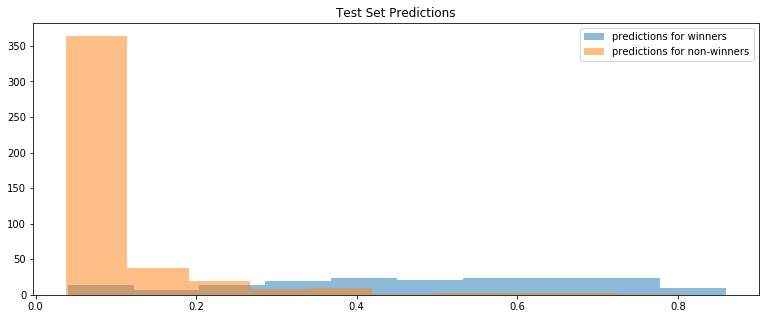

In [27]:
## make a plot
fig,ax = plt.subplots(1,1,figsize=(13,5))
plt.hist(preds_test[(df_test.winner==1).values],alpha=.5,
         label='predictions for winners');
plt.hist(preds_test[(df_test.winner==0).values],alpha=.5,
         label='predictions for non-winners');
plt.legend();
plt.title('Test Set Predictions');

In [28]:
## put the raw predictions in the test dataframe so we can use df.groupy
df_test['pred_raw'] = preds_test

In [29]:
## get dictionaries mappying race index to index of predicted and true winners, this time on test set
preds_test = df_test.groupby('race_index').pred_raw.apply(lambda x: x.idxmax()).to_dict()
true_test = df_test.groupby('race_index').winner.apply(lambda x: x.idxmax()).to_dict()

In [30]:
## get test accuracy on race level
acc = np.mean([preds_test[race_ind]==true_test[race_ind] for race_ind in df_test.race_index.unique()])
acc

0.88135593220338981

88% accuracy is not that bad! Considering I used nothing but tweets and imbued no prior knowledge.

Let's take a quick look at where the model failed. First, here's the highest raw prediction (the probability that the candidate will win) for a non-winner:

In [31]:
df_test[~df_test.winner.astype(bool)].sort_values('pred_raw',ascending=False).head(1)

,candidate,tweets,replies,retweets,favorites,winner,race_index,pred_raw
511,Sarah Lloyd,[\nours increase when more anxious as well. bu...,"[2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 0.0, 5.0, 1.0, ...","[1.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 5.0, 4.0, ...",0,151,0.801264


In [32]:
## take a look at 30 of the tweets for Sarah Lloyd
df_test[~df_test.winner.astype(bool)].sort_values('pred_raw',ascending=False).tweets.iloc[0][0:30]

array([ '\nours increase when more anxious as well. but also notice everyday stuff after hearing Sarah Lloyd talk.\n',
       '\n2/2 having heard Sarah Lloyd, wondering about under-developed sensory system and using sensory integration.\n',
       '\n@lloyd4wi Sarah Lloyd finds #frogandtoad in #littlefreelibrary.  #flipitdem.pic.twitter.com/Z6j2wtPXU9\n',
       '\n@lloyd4wi Sarah Lloyd meeting voters who want a change. #flipitdem\n@WisDems know what a difference she will makepic.twitter.com/f8Xt7qBYc5\n',
       '\nSarah Lloyd @lloyd4wi out and about in #fdl.  @WisDems working to #flipitdem\n@Khary4Congress\n@Ryan_Solen \n@NelsonforWI\n@MaryHoeftForWIpic.twitter.com/WW49weFkLX\n',
       '\nSarah Lloyd smart, articulate candidate http://fondul.ac/2ezRmr8\xa0 #wiunion #wiright #wipolitics\n',
       '\nWI-06 Sarah LLOYD\n4 CONGRESS@FlipItDem\n@lloyd4wi#BlueWI\nFLIP  HOUSE  BLUE & \nMadame POTUSDem Majority\nDEFEAT Glenn Grothmanpic.twitter.com/9Dw5MUnuhk\n',
       '\nDonald Trump & Gl

In [33]:
## the race Lloyd lost
df_test[df_test.race_index==151]

,candidate,tweets,replies,retweets,favorites,winner,race_index,pred_raw
510,Glenn Grothman,"[\nThey're ubiquitous up here. My ""brand Glen...","[1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 5.0, 0.0, 0.0, 5.0, 0.0, 1.0, 0.0, ...","[1.0, 1.0, 5.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, ...",1,151,0.483090
511,Sarah Lloyd,[\nours increase when more anxious as well. bu...,"[2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 0.0, 5.0, 1.0, ...","[1.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 5.0, 4.0, ...",0,151,0.801264
512,Jeff Dahlke,[\nJeff Dahlke. I'm only voting him bc he boug...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 4.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 13.0, 0.0, 0.0, 0.0]",0,151,0.048588


In [34]:
print(race_metadata_2016.loc[151])
print(race_metadata_2016.loc[151].Result)

Race                                             Wisconsin 6
Result     [["Glenn Grothman", "Republican", 57.2], ["Sar...
Chamber                                                House
winner                                        Glenn Grothman
Name: 151, dtype: object
[["Glenn Grothman", "Republican", 57.2], ["Sarah Lloyd", "Democratic", 37.3], ["Jeff Dahlke", "Independent", 5.5]]


So this looks like a race where Democratic enthusiasm (or twitter activism) was high but the Republican won. It could also have a little to do with the fact that Sarah Lloyd is also the name of a British travel writer but not sure.

Now let's take a look at the lowest raw prediction for a winner:

In [35]:
df_test[df_test.winner.astype(bool)].sort_values('pred_raw').head(1)

,candidate,tweets,replies,retweets,favorites,winner,race_index,pred_raw
240,Jason T. Smith,"[\nEver ask ""Why ain't my SH*T selling?"" Join ...","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 4.0, 0.0]",1,69,0.039982


In [36]:
## this race
df_test[df_test.race_index==69]

,candidate,tweets,replies,retweets,favorites,winner,race_index,pred_raw
240,Jason T. Smith,"[\nEver ask ""Why ain't my SH*T selling?"" Join ...","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 4.0, 0.0]",1,69,0.039982
241,Dave Cowell,[\nJust so happens the person who runs Armatur...,"[0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 1.0, 0.0, ...","[1.0, 2.0, 1.0, 3.0, 0.0, 21.0, 2.0, 2.0, 1.0,...",0,69,0.051360
242,Jonathan Shell,[],[],[],[],0,69,0.040377


In [37]:
print(race_metadata_2016.loc[69])
print(race_metadata_2016.loc[69].Result)

Race                                              Missouri 8
Result     [["Jason T. Smith", "Republican", 74.4], ["Dav...
Chamber                                                House
winner                                        Jason T. Smith
Name: 69, dtype: object
[["Jason T. Smith", "Republican", 74.4], ["Dave Cowell", "Democratic", 22.7], ["Jonathan Shell", "Libertarian", 2.9]]


This one makes more sense to me - "Jason T. Smith" is what I have as the candidate's name (from Wikipedia). Since twitter search looks for an exact string match, it makes sense that the model would not have a good read on this candidate since it's unlikely for people to tweet a name with a middle initial.

Stay tuned: as a next step, I plan to collect the tweets for the month leading up to the 2018 congressional races and post my predictions on election day.